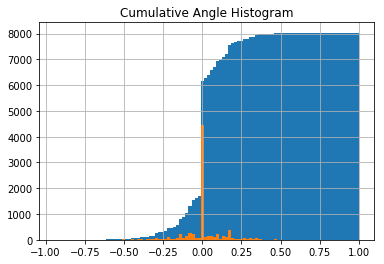

In [2]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from pylab import rcParams, imshow
import cv2
import numpy as np
import collections
from sklearn.model_selection import train_test_split


origin_image_shape = (160, 320, 3)
data_dir = "data/"

def read_driving_log(csv_file = data_dir +'driving_log.csv'):
    return pd.read_csv(csv_file)

       
def plot_steering_angles(angles):
    plt.hist(angles, bins=100, cumulative=True)
    plt.title("Angle Histogram (histogram and cumulative histogram overlayed)")
    plt.grid(True)

    plt.hist(angles, bins=100)
    plt.title("Cumulative Angle Histogram")
    plt.grid(True)

    plt.plot();


driving_log = read_driving_log()

plot_steering_angles(driving_log["steering"])

The above image shows the histogram and the cumulative histogram superimposed. From this we can see that that overwhelming majority of angels are zero. How many are exactly zero ?

In [2]:
driving_log["steering"].count()
angles = driving_log["steering"]
nonzero_angles = angles[angles > 0.0].count()
zero_angles = angles[angles == 0.0].count()

print("Angle bigger than zero   : {}".format(nonzero_angles))
print("Angle equal to zero      : {}".format(zero_angles))
print("% of zero angles         : {:.2f}".format(zero_angles / (nonzero_angles + zero_angles) * 100))

Angle bigger than zero   : 1900
Angle equal to zero      : 4361
% of zero angles         : 69.65


Conclusion: We need to balance the data set by using image aumentation.
Here are a couple of helper functions for this:

In [4]:
def read_image(filename):
    image = cv2.imread(filename)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def flip(image, angle):
    image = np.array(image)
    flipped = cv2.flip(image, 1) # 1==y axis
    angle = -angle
    return flipped, angle
    
def crop(image):
    image = image[60:130, 50:250]
    return image

def random_select_lcr(image_locations):
    lrc_select = np.random.randint(3)
    angle = image_locations.get("steering")
    
    deps = {0 : ("left", angle + 0.25),
            1 : ("center", angle),
            2 : ("right", angle -0.25)
           }
    direction, angle_shift = deps[lrc_select]
    path_file = image_locations.get(direction).strip()
    return direction, angle_shift, path_file
    
def jitter(img):
    # see https://stackoverflow.com/questions/35152636/random-flipping-and-rgb-jittering-slight-value-change-of-image
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    RGBshifted = np.dstack( (
        np.roll(R, 10, axis=0), 
        np.roll(G, 10, axis=1), 
        np.roll(B, -10, axis=0)
        ))
    return RGBshifted

def rand_brightness(img):
    # taken from https://github.com/vxy10/ImageAugmentation
    image1 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def normalize(img):
    return (img - 128.) / 128.
    

right, -0.09
flipped, -0.16
jittered, -0.09
brightness, -0.09
left, 0.20
flipped, 0.05
jittered, 0.20
brightness, 0.20


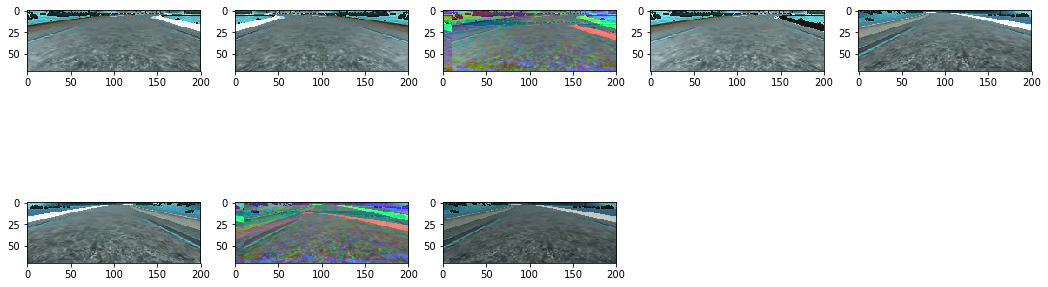

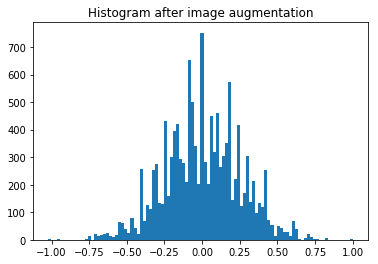

In [16]:
def image_processing_step(sample, keep_probability=0.1, angle_threshold=0.01):
    images = []
    path_to_center_image = sample.get("center")
    angle_of_center_image = sample.get("steering")
    if abs(angle_of_center_image) <= angle_threshold and np.random.uniform() > keep_probability:
        return images
    
    # randomly select center, right or left image and adjust angle by (-) 0.25 if not center
    direction, angle, img_path = random_select_lcr(sample)
    original_image = crop(read_image(data_dir + img_path))
    images.append((direction, angle, original_image))

    # flip image horizontally
    flipped, flipped_angle = flip(original_image, angle_of_center_image)
    images.append(("flipped", flipped_angle, flipped))

    # add jitter
    jittered = jitter(original_image)
    images.append(("jittered", angle, jittered))

    # adjust random brightness
    random_b = rand_brightness(original_image)
    images.append(("brightness", angle, random_b))

    return images
    
    
def display_images_grid(images, rows, cols, figure_size=(18,10)):
    gs1 = gridspec.GridSpec(rows, cols)
    gs1.update(wspace=0.00, hspace=0.02) 
    plt.figure(figsize=figure_size)
    for i in range(0,len(images)):
        direction, angle, img = images[i]
        ax1 = plt.subplot(gs1[i])
        ax1.set_title("{}, {:.2f}".format(direction, angle))
        ax1.set_aspect('equal')
        plt.subplot(rows,cols,i+1)
        plt.imshow(img)
        print("{}, {:.2f}".format(direction, angle))
    plt.show();
    

train, test = train_test_split(driving_log, test_size = 0.2)
sample = train.sample(5)
pr = []
for index, row in sample.iterrows():
    pr.extend(image_processing_step(row))

display_images_grid(pr, 3, 5)

samples = train.sample(frac=1)
processed = []
for index, row in samples.iterrows():
    pr = image_processing_step(row)
    if len(pr) != 0:
        processed.extend(pr)

direction, y_train, X_train = zip(*processed)
X_train = np.array(X_train)
y_train = np.array(y_train)

test_images_path = np.array(test["center"])
X_test = []
for i in range(0,len(test_images_path)):
    X_test.append(crop(read_image(data_dir + test_images_path[i])))

X_test = np.array(X_test)
y_test = np.array(test["steering"])

plt.hist(y_train, bins=100);
plt.title("Histogram after image augmentation")
plt.show;


In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Activation, Dropout, BatchNormalization, ELU, \
    AveragePooling2D
from keras.layers.pooling import MaxPooling2D

img_shape = (70,200,3)

def NVIDIA():
    # NVIDIA Model, as per https://arxiv.org/pdf/1604.07316.pdf, but with ELU and BatchNorm Layer
    model = Sequential()
    model.add(Lambda(lambda x: (x - 128.) / 128., input_shape=img_shape))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='elu', strides=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='elu', strides=(1, 1)))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dropout(.5))
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(.2))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation='tanh'))
    return model

model = NVIDIA()
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            shuffle=True,
            epochs=8,
            verbose=1,
            batch_size=256)

model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 70, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________